C:\Users\salaz\AppData\Local\Temp\ipykernel_9056\1900724723.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nasdaq = yf.download(INDEX_TICKER, start=START, end=END, progress=False)
C:\Users\salaz\AppData\Local\Temp\ipykernel_9056\1900724723.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)
C:\Users\salaz\AppData\Local\Temp\ipykernel_9056\1900724723.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)
C:\Users\salaz\AppData\Local\Temp\ipykernel_9056\1900724723.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)
C:\Users\salaz\AppData\Local\Temp\ipykernel_9056\1900724723.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df 


REPORTE DETALLADO POR ACTIVO (2006 - 2026)
Ticker Utilidad Neta ($) Retorno Sentinel % Retorno B&H % Max DD %  Trades
  AAPL       $750,174.31           3750.87%     12026.70%  -37.18%      78
  MSFT       $148,668.39            743.34%      2484.12%  -30.85%      74
  AMZN       $294,993.09           1474.97%      9602.40%  -53.22%      79
 GOOGL       $237,026.50           1185.13%      2795.48%  -31.08%      70
  NVDA     $2,219,310.73          11096.55%     63767.31%  -58.15%      68

RESUMEN CONSOLIDADO VS BENCHMARKS
               Estrategia Utilidad Neta Total Retorno Total % Max Drawdown %
Sentinel Portfolio (Lite)       $4,089,780.95        4089.78%        -36.42%
   Buy & Hold (Stock Mix)      $18,135,199.97       18135.20%        -66.11%
        Nasdaq 100 (^NDX)       $1,403,029.82        1403.03%        -53.71%


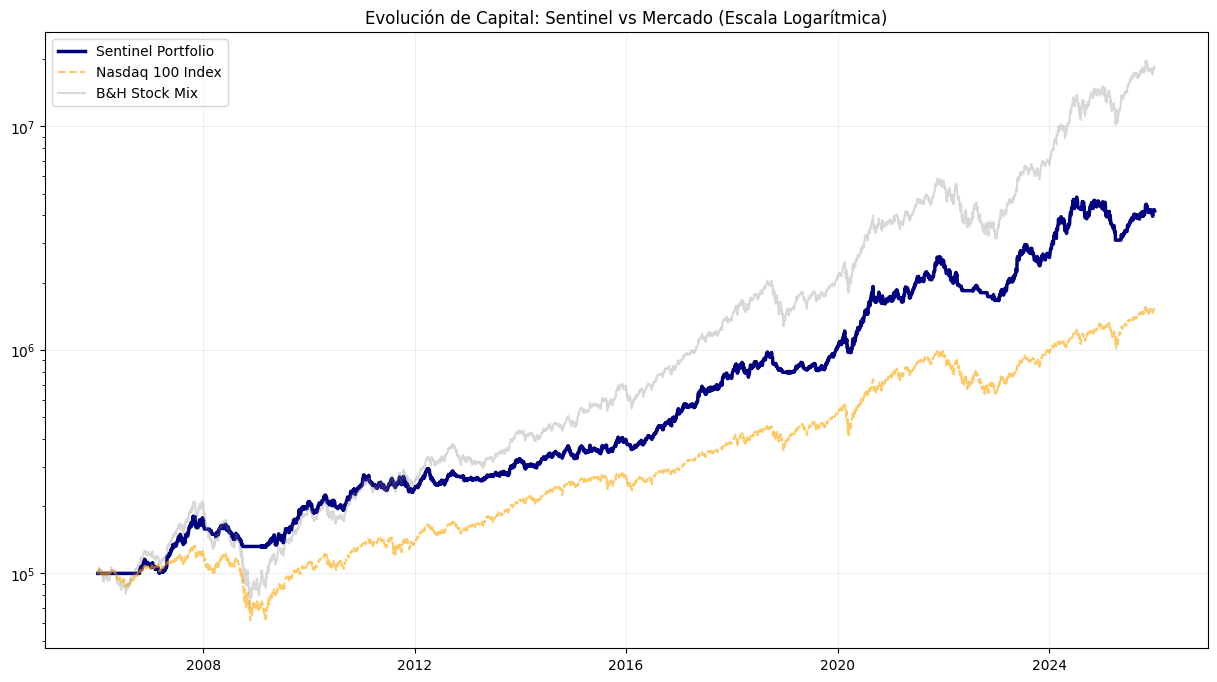

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURACIÓN SENTINEL V3.3 LITE + NASDAQ
# ==========================================
TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA"]
INDEX_TICKER = "^NDX" 
START, END = "2006-01-01", "2026-01-01"
CAPITAL_INICIAL = 100000
CAPITAL_POR_TICKER = CAPITAL_INICIAL / len(TICKERS)

def run_full_sentinel_audit():
    portfolio_equity = pd.DataFrame()
    bh_equity_total = pd.DataFrame()
    reporte_individual = []
    
    # 1. Benchmark Nasdaq 100
    nasdaq = yf.download(INDEX_TICKER, start=START, end=END, progress=False)
    nasdaq.columns = nasdaq.columns.get_level_values(0)
    nasdaq_equity = (CAPITAL_INICIAL / nasdaq['Close'].iloc[0]) * nasdaq['Close']

    for ticker in TICKERS:
        df = yf.download(ticker, start=START, end=END, progress=False)
        df.columns = df.columns.get_level_values(0)

        # INDICADORES
        df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
        df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()
        tr = np.maximum(df['High']-df['Low'], np.maximum(abs(df['High']-df['Close'].shift(1)), abs(df['Low']-df['Close'].shift(1))))
        df['ATR'] = tr.rolling(window=22).mean()

        balance = CAPITAL_POR_TICKER
        pos, shares, trailing_stop, n_trades = 0, 0, 0, 0
        equity_curve = []
        
        for i in range(len(df)):
            price = df['Close'].iloc[i]
            if i < 200: 
                equity_curve.append(balance); continue

            # SALIDA (Trailing Stop)
            if pos == 1:
                trailing_stop = max(trailing_stop, price - (3.5 * df['ATR'].iloc[i]))
                if price < trailing_stop:
                    balance = shares * price
                    pos, shares = 0, 0
            
            # ENTRADA
            if pos == 0:
                if price > df['EMA200'].iloc[i] and price > df['EMA20'].iloc[i]:
                    pos, shares, n_trades = 1, balance / price, n_trades + 1
                    trailing_stop = price - (3 * df['ATR'].iloc[i])

            equity_curve.append((shares * price) if pos == 1 else balance)

        # Metricas Individuales
        eq_series = pd.Series(equity_curve)
        bh_series = (CAPITAL_POR_TICKER / df['Close'].iloc[0]) * df['Close']
        
        reporte_individual.append({
            'Ticker': ticker,
            'Utilidad Neta ($)': balance - CAPITAL_POR_TICKER,
            'Retorno Sentinel %': (balance / CAPITAL_POR_TICKER - 1) * 100,
            'Retorno B&H %': (df['Close'].iloc[-1] / df['Close'].iloc[0] - 1) * 100,
            'Max DD %': ((eq_series - eq_series.cummax()) / eq_series.cummax()).min() * 100,
            'Trades': n_trades
        })
        
        portfolio_equity[ticker] = equity_curve
        bh_equity_total[ticker] = bh_series

    # --- PROCESAMIENTO GLOBAL ---
    portfolio_equity.index = df.index[len(df)-len(equity_curve):]
    total_sentinel = portfolio_equity.sum(axis=1)
    total_bh = bh_equity_total.sum(axis=1)

    # REPORTE 1: DESGLOSE POR EMPRESA
    print("\n" + "="*120)
    print(f"REPORTE DETALLADO POR ACTIVO ({START[:4]} - {END[:4]})")
    print("="*120)
    print(pd.DataFrame(reporte_individual).to_string(index=False, formatters={
        'Utilidad Neta ($)': '${:,.2f}'.format,
        'Retorno Sentinel %': '{:.2f}%'.format,
        'Retorno B&H %': '{:.2f}%'.format,
        'Max DD %': '{:.2f}%'.format
    }))

    # REPORTE 2: COMPARATIVA GLOBAL
    def get_max_dd(series): return ((series - series.cummax()) / series.cummax()).min() * 100
    
    global_stats = []
    for name, series in [("Sentinel Portfolio (Lite)", total_sentinel), 
                         ("Buy & Hold (Stock Mix)", total_bh), 
                         ("Nasdaq 100 (^NDX)", nasdaq_equity)]:
        global_stats.append({
            'Estrategia': name,
            'Utilidad Neta Total': series.iloc[-1] - CAPITAL_INICIAL,
            'Retorno Total %': (series.iloc[-1] / CAPITAL_INICIAL - 1) * 100,
            'Max Drawdown %': get_max_dd(series)
        })

    print("\n" + "="*120)
    print("RESUMEN CONSOLIDADO VS BENCHMARKS")
    print("="*120)
    print(pd.DataFrame(global_stats).to_string(index=False, formatters={
        'Utilidad Neta Total': '${:,.2f}'.format,
        'Retorno Total %': '{:.2f}%'.format,
        'Max Drawdown %': '{:.2f}%'.format
    }))

    # GRÁFICA
    plt.figure(figsize=(15, 8))
    plt.plot(total_sentinel, label='Sentinel Portfolio', color='navy', lw=2.5)
    plt.plot(nasdaq_equity, label='Nasdaq 100 Index', color='orange', alpha=0.6, ls='--')
    plt.plot(total_bh, label='B&H Stock Mix', color='gray', alpha=0.3)
    plt.yscale('log')
    plt.title("Evolución de Capital: Sentinel vs Mercado (Escala Logarítmica)")
    plt.legend(); plt.grid(True, alpha=0.2); plt.show()

run_full_sentinel_audit()